# CASE 1 - Coronary heart disease

Hanna Haimakainen <br>
Last edited: 4.2.2018 <br>
Cognitive systems for health technology applications <br>
Helsinki Metropolia University of Applied Sciences

## 1. Objectives

 * Read and reprocess the UCI heart disease dataset in <https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/> <br>
 * Describe the contents of dataset.
 * Create and train a dense neural network to predict the presence of heart disease.
 
 <br>
 <br>
 Only ready processed versions of dataset were used in this work. These versions had a 14-version subset of larger original datasets, and some corrupted samples were removed. I didn't find a need to use the raw data so I didn't use the raw files.

## 2. Examine the input dataset

Dataset variable definitions, table derived from course lecture material. "ca" and "thal" variables are left out from the final model, as they are results of invasive, disease spesific examination procedures. <br><br>

Table shows basic definitions for dataset variables, and I also included quesses for usable datatypes for each variable. The format of datatypes is designed to best fit the input of neural network. Categorical and unordered variables were decided to be encoded with one-hot encoding to prevent neural network interpreting them as numerical variables. Binary categorical values were encoded with values -1 and 1 to separate them equal distance around zero.



| _var name_ |  _definition_                                                                                                                                                                  | _data class/type_                                                              |
|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| age        | Age in years                                                                                                                                                                  | numerical                                                                      |
| sex        | sex (0 = female; 1 = male)                                                                                                                                                    | binary categorical,  code to between -1 and 1                                  |
| cp         | cheast pain type <br> - value 1: typical angina<br> - value 2: atypical angina<br> - value 3: non-anginal pain<br> - value 4: asymptomatic                                                     | unordered categorical, use to_categorical to  create categorical binary vector |
| trestbps   | resting blood pressure<br>  (in mmHg on admission to hospital)                                                                                                                    | numerical                                                                      |
| chol       | serum cholesterol in mg/dl                                                                                                                                                    | numerical                                                                      |
| fbs        | fasting blood sugar >120mg/dl<br> 1 = true ; 0 = false                                                                                                                            | binary, but you can use 0.. 1 range as its ordered                                          |
| restecg    | resting cardiographic results<br> - value 0: normal<br> - value 1: having ST-T wave abnormality<br> - value 2: showing propable or definite<br>left venticular hypertrophy | categorical, is this ordered or should binary vector be used?                  |
| thalach    | maximum heart rate achieved                                                                                                                                                   | numerical                                                                      |
| exang      | exercise-induced angina 1= yes; 0= no                                                                                                                                         | binary categorical, code as -1 and 1                                           |
| oldpeak    | ST depression induced by exercise  relative to rest                                                                                                                           | ?                                                                              |
| slope      | the slope of the peak exercise ST<br> - value 1: upsloping<br> - value 2: flat<br> - value 3: downsloping                                                                                 | categorical, unordered use binary vector                                       |
| ca         | number of major vessels (0-3) colored by fluoroscopy                                                                                                                          | categorical, but ordered. Keep them as is?                               |
| thal       | 3 = normal; 6 = fixed defect; 7 = reversable defect                                                                                                                           | categorical, unordered. Use binary vector                                      |
| num        | diagnosis of heart disease (angiographic disease status)<br> - value 0: <50% diameter narrowing<br> - value 1: >50% diameter narrowing                                                |  *LABEL data* categorical but ordered, was this between 0 .. 4?                |

## 3. Read and examine the input datasets

In [61]:
#import libraries

import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt

from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [62]:
columns = ["age","sex","cp","trestbps","chol","fbs","restecg",
          "thalach","exang","oldpeak","slope","ca","thal","num"]


df_cleve = pd.read_csv("Heart-disease/processed.cleveland.data.txt",names=columns,na_values="?")
df_hungarian = pd.read_csv("Heart-disease/processed.hungarian.data.txt",names=columns,na_values="?")
df_swiss = pd.read_csv("Heart-disease/processed.switzerland.data.txt",names=columns,na_values="?")
df_va = pd.read_csv("Heart-disease/processed.va.data.txt",names=columns,na_values="?")


# concatenate all datasets one after each other
df = pd.concat([df_cleve,df_hungarian,df_swiss,df_va])

#drop ca anf thal from model, as those are not required
df = df.drop(['ca','thal'],axis=1)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,1


There are lots of missing values in the last three datasets (visible in the last rows in above listing). Actually almost all of the samples are missing some variables. Fill up the missing values:

In [63]:
# remove missing values with mode value
# this is not good with categorical and unordered values
df = df.where(~df.isnull(),df.mode(),axis=1)
df.shape

(920, 12)

Check if there's high correlation between any of the values.

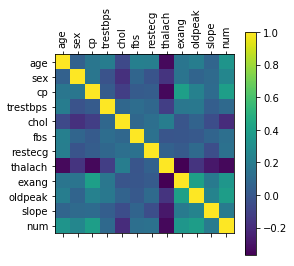

In [64]:
# create a temporary columns list for plotting
cols = columns
cols.remove("thal")
cols.remove("ca")

plt.matshow(df.corr())
ax = plt.gca()
ax.set_xticks(np.arange(0,len(cols)))
ax.set_yticks(np.arange(0,len(cols)))
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#plt.yticklabels(numeric_cols)
plt.colorbar()
plt.show()

There are weak correlations visible between the last four variables: exang,oldpeak,slope,num _(exercise-induced angina, ST-depression from exercise, slope of peak exercise ST, disease diagnosis)_. There is also weak correlation between "exang" and "cp" (exercise-induced angina and chest pain type). 
<br><br>
##### Plot histograms for all the variables to show the data distributions:


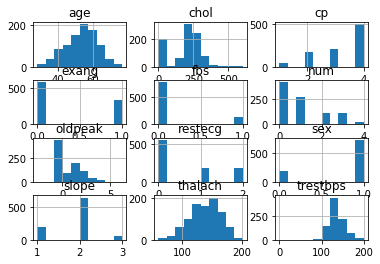

In [65]:
df.hist()
plt.show()

Based on the histograms it is evident that variables age, chol, thalach and trestbps are numerical variables and follow mostly gaussian distribution. Cholestherol variable (chol) has high number of outliers at value 0. Some of the used datasets didn't store the chol information and it is replaced by 0 in data.
<br><br>
Categorical variables are shown as distinct separate bars in the histograms. Not many of these variables are ordered. It is evident that the dataset is not very uniform with these: eg. the gender ratio is highly biased towards men (number 1 in "sex" variable).

## 4. Scale and preprocess the dataset

* Scale all numerical values into range -1,1 by removing the mean of varaible and dividing by 2*standard_deviation. 
* Use dummy/one-hot encoding with all categorical variables

In [66]:
#scale age variable
mean = df['age'].mean()
std = df['age'].std()
df.loc[:,'age'] -=mean
df.loc[:,'age'] /=(2*std)

#encode sex into binary -1,1
df.loc[:,'sex']*2-1

#create categorical binary vector for chest pain type (one-hot encoding)
# cp_vector has now 5 columns where only last four contain the ON/OFF bit for that category.
# the result looks like eg. [0,0,1.0,0] for category 3 of possibilities [1,2,3,4]

df = pd.concat([df.drop('cp', axis=1), pd.get_dummies(df['cp'],prefix="cp")], axis=1)



#normalize trestbps
mean = df['trestbps'].mean()
std = df['trestbps'].std()
df['trestbps']-=mean
df['trestbps']/=(2*std)

#normalize cholesterol
mean = df['chol'].mean()
std = df['chol'].std()
df['chol']-=mean
df['chol']/=(2*std)


#leave fbs as is, as it is binary categorical but ordered

#restecg is propably ordered and categorical, but use one-hot encoding for now
# possible values are 0,1,2 -> [[1,0,0],[0,1,0],[0,0,1]]
df = pd.concat([df.drop('restecg', axis=1), pd.get_dummies(df['restecg'],prefix='restecg')], axis=1)

# normalize thalach
mean = df['thalach'].mean()
std = df['thalach'].std()
df['thalach']-=mean
df['thalach']/=(2*std)

#encode exercise-induced angina to binary -1 and 1
df['exang']=df['exang']*2-1

#normalize oldpeak
mean = df['oldpeak'].mean()
std = df['oldpeak'].std()
df['oldpeak']-=mean
df['oldpeak']/=(2*std)


#encode ST-slope into one-hot encoding
df = pd.concat([df.drop('slope', axis=1), pd.get_dummies(df['slope'],prefix='slope')], axis=1)

#drop ca anf thal from model, as those are not required

'''
#keep ca as it is (ordered values between 0 and 3)

#encode thal into three groups and one-hot encode them
# has originally three categories numbered far away from each other
thal_onehot = pd.get_dummies(df['thal'],prefix="thal")
df = df.drop('thal',axis=1)
df = df.join(thal_onehot)
'''


#encode label used for defining sickness, "num" as binary True/False
i = df['num']>0
df.loc[i,"num"] = 1

print(df.shape)
df

(920, 19)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0
0,0.503419,1.0,0.365206,0.176166,1.0,0.231314,-1.0,0.687562,0,1,0,0,0,0,0,1,0,0,1
1,0.715628,1.0,0.766660,0.407485,0.0,-0.598349,1.0,0.316016,1,0,0,0,1,0,0,1,0,1,0
2,0.715628,1.0,-0.303883,0.158707,0.0,-0.183518,1.0,0.826892,1,0,0,0,1,0,0,1,0,1,0
3,-0.875937,1.0,-0.036247,0.250362,0.0,0.962207,-1.0,1.244882,0,0,0,1,0,1,0,0,0,0,1
4,-0.663729,0.0,-0.036247,0.049594,0.0,0.665899,-1.0,0.269573,0,0,1,0,0,0,0,1,1,0,0
5,0.132054,1.0,-0.303883,0.189259,0.0,0.784422,-1.0,-0.009087,0,0,1,0,0,1,0,0,1,0,0
6,0.450367,0.0,0.231389,0.328924,0.0,0.428852,-1.0,1.291325,1,0,0,0,1,0,0,1,0,0,1
7,0.185106,0.0,-0.303883,0.704273,0.0,0.488114,1.0,-0.101973,0,0,0,0,1,1,0,0,1,0,0
8,0.503419,1.0,-0.036247,0.267821,0.0,0.172052,-1.0,0.269573,1,0,0,0,1,0,0,1,0,1,0
9,-0.027103,1.0,0.231389,0.045230,1.0,0.330083,1.0,1.059109,1,0,0,0,1,0,0,1,0,0,1


## 5. Prepare dataset for neural network. Split dataset into test and training/validation set
Split the dataset into separate "training" and "test" datasets. Save contents of disease diagnosis -variable (num) as labels and split them too.

In [67]:
#shuffle the rows of dataframe
df = df.sample(frac=1)


#save "num" column as labels
df_labels = df['num']
#drop 'num column from training set as its the labels
df_data = df.drop('num',axis=1)

data = df_data.values
labels = df_labels.values

#split into training/validation set and final test set
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.15)

print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)

(782, 18)
(138, 18)
(782,)


_Input is now vector of 20 parameters because of dummy encoding_
<br><br>
__As the training dataset is rather small, less than 1000 samples, use k-fold validation when training the model __
<br>
In k-fold validation the training dataset is divided into a _k_ number of pieces, _folds_. One of these folds is selected as a validation group and others are used in training. A separate neural network model is trained for all the _k_ possible combinations of validation/training folds, and final model performance is considered as an average of the results.
<br><br>
__Stratified k-fold validation__ is a method which is used when output/results value are not falling uniformly in all output categories (eg. much higher number of True outcomes than False outcomes). Stratified validation tries to preserve the the output class distribution while deciding the folds, so that each of the folds would have the same original distribution of outcomes.
<br>
https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
<br>
<br>
Let's check the output/label variable distribution:

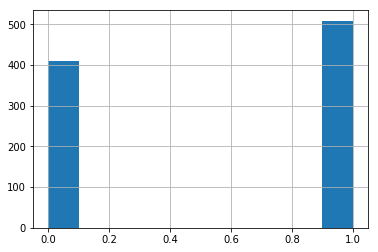

In [68]:
df["num"].hist()
plt.show()

The output distribution is rather equal in this dataset. Let's still use the stratified k-folding :)

## 6. Define the neural network model
Model needs to be defined beforehands in order to use it repeatedly in k-folding algorithm.
<br>
<br>
Create a neural network with three hidden layers. Use droptous between the layer to prevent overfitting. Use regularizers in all hidden layers to keep weights in sensible range and to avoid overfitting.

In [69]:
def create_model(inputShape):
    network = keras.models.Sequential()
    #add first layer
    network.add(keras.layers.Dense(128,input_shape=(inputShape,),activation='relu',kernel_regularizer=regularizers.l1_l2(0.001)))
    network.add(keras.layers.Dropout(0.5))
    network.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(0.001)))
    network.add(keras.layers.Dropout(0.5))
    network.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(0.001)))
    network.add(keras.layers.Dropout(0.5))
 

    network.add(keras.layers.Dense(1,activation='sigmoid'))

    network.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    
    return network

## 7. Train multiple models in a k-folding loop

In [70]:
#http://scikit-learn.org/stable/modules/cross_validation.html
# https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416

#use stratified K-folding to ensure that each fold has similar distribution of True/False disease labels
#there are more samples with disease tham without: let it be so in all of the folds

nFolds = 5
skf = StratifiedKFold(n_splits=nFolds)


hist = []
evaluated = []

for (train_ind, val_ind) in skf.split(data_train, labels_train):
    #print(train_ind)
    #print(val_ind)
    # define training and test set for this fold
    x_train, x_val = data_train[train_ind],data_train[val_ind]
    y_train, y_val = labels_train[train_ind],labels_train[val_ind]
 

    model = None
    model = create_model(x_train.shape[1])
    
    hist.append(      model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val,y_val),shuffle=False,verbose=0) )
    evaluated.append( model.evaluate(data_test,labels_test) )
    
    

138/138 [==============================] - 0s 59us/step


## 8. Visualize the results and compute average performances

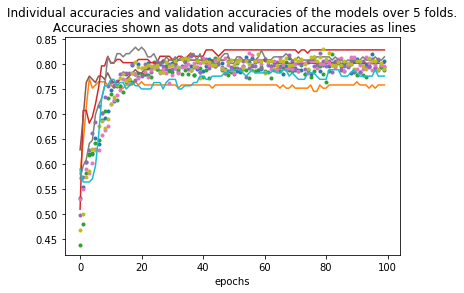

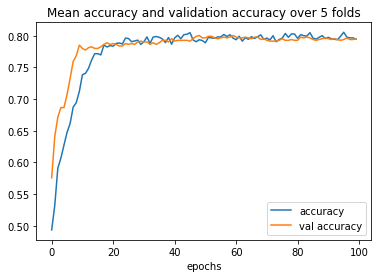

In [71]:
ACC = np.zeros(len(hist[0].epoch),)
VAL_ACC = np.zeros(len(hist[0].epoch),)

plt.plot()

for h in hist:
    ACC += h.history['acc']
    VAL_ACC += h.history['val_acc']
    
    plt.plot(h.history['acc'],'.')
    plt.plot(h.history['val_acc'],'-')

plt.title("Individual accuracies and validation accuracies of the models over "+str(nFolds) + " folds.\n Accuracies shown as dots and validation accuracies as lines")
plt.xlabel("epochs")
plt.show()

ACC /= nFolds
VAL_ACC /= nFolds

plt.plot(ACC)
plt.plot(VAL_ACC)
plt.title("Mean accuracy and validation accuracy over "+str(nFolds) + " folds")
plt.legend(['accuracy','val accuracy'])
plt.xlabel("epochs")
plt.show()

Above accuracy graphs show that k-folding gives better representation of model's actual accuracy than running just a single training/validation dataset. In the upper image (showing all the trained models) most of the models gave similar accuracies but there were also outliers showing way worse (or better) performance. If only a single model was trained, the amount of uncertainty in the results would be unknown. Average knowledge of accuracies helps much when model hyperparameters are iterated.

#### Evaluate the model with original test data
Compute average accuracy for test dataset

In [72]:
ev = np.array(evaluated)
print("Test group accuracy over all folds")
print(ev[:,1])
print("")
print("avg: {} , std: {}".format((np.mean(ev[:,1])),np.std(ev[:,1])))

Test group accuracy over all folds
[ 0.80434783  0.79710145  0.81884058  0.78985507  0.78985507]

avg: 0.8000000008638354 , std: 0.010845383729779551


Computed test set accuracy is close to 80% and with really low standard deviation between the _k_ different models. This shows that all models perform close to the same way.

## 9.Results and Discussion
An overall test and validation group accuracy of close to 80% was achieved by using a three-hidden-layer neural network. The accuracy was tested by using 5-fold validation by simultaneously training multiple models with different permutations of training/validation data. The standard deviation of test/evaluation accuracy was 1 percentage point, which shows all the models had similar accuracies and results. 
<br><br>
Earlier research suggests that ~78% accuracy with heart disease dataset can be achieved with decision trees [Feature Analysis of Coronary Artery Heart Disease Data Sets]. Achieved accuracy with now-designed three-layer neural network is in the same ballpark range. This supports the hypothesis that neural network succeeds in this classifying task.

__Pitfalls__
Whole dataset is shuffled in the beginning before splitting data into _training/validation_ and _test_ sets. This results in _test_ set not being completely separated from training set over consecutive runs as shuffling randomizes the sets. This leads to information leakage into model over runs when designer permutes the model hyperparameters.
<br>
<br>
The dataset has only a small number of samples, some of them with invalid values, which limits the accuracy and complexity of usable model. More samples would be needed to train more accurate and larger model.


[Feature Analysis of Coronary Artery Heart Disease Data Sets]: https://doi.org/10.1016/j.procs.2015.09.132